In [1]:
# Block 1: Imports
import os
os.environ.setdefault("DDE_BACKEND", "pytorch")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import time
import random
import json
import math
from collections import OrderedDict

import numpy as np
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

import MAS_library as MASL
from torch.amp import GradScaler, autocast

In [2]:
# Block 2: Run/Paths/IO
RUN_NAME = "T2ROI-emph V2 Compare"
RESUME_FROM_CHECKPOINT = False
RESET_LOGS_ON_FRESH_START = True

BASE_DIR    = "./runs"
RUN_DIR     = os.path.join(BASE_DIR, RUN_NAME)
CKPT_DIR    = os.path.join(RUN_DIR, "checkpoints")
LOGS_DIR    = os.path.join(RUN_DIR, "logs")
DATA_DIR    = "./data"
PRECOMP_DIR = os.path.join(DATA_DIR, "precomputed")

checkpoint_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_checkpoint.pt")
best_model_path   = os.path.join(CKPT_DIR, f"{RUN_NAME}_best_model.pt")
metrics_log_path  = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_metrics.txt")
train_log_path    = os.path.join(LOGS_DIR,  f"{RUN_NAME}_train_log.txt")
diag_jsonl_path   = os.path.join(LOGS_DIR,  f"{RUN_NAME}_epoch_diag.jsonl")

for d in (BASE_DIR, RUN_DIR, CKPT_DIR, LOGS_DIR, DATA_DIR, PRECOMP_DIR):
    os.makedirs(d, exist_ok=True)

def _append_train_line(text: str):
    try:
        with open(train_log_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write train log: {e}")

def _append_jsonl_line(text: str):
    try:
        with open(diag_jsonl_path, "a", encoding="utf-8") as f:
            f.write(text.rstrip() + "\n")
    except Exception as e:
        print(f"[warn] couldn't write diag jsonl: {e}")

print(f"[run] RUN_NAME={RUN_NAME}")
print(f"[run] RUN_DIR={RUN_DIR}")
print(f"[run] CKPT_DIR={CKPT_DIR}")
print(f"[run] LOGS_DIR={LOGS_DIR}")
print(f"[run] checkpoint_path={checkpoint_path}")
print(f"[run] best_model_path={best_model_path}")
print(f"[run] metrics_log_path={metrics_log_path}")
print(f"[run] train_log_path={train_log_path}")
print(f"[run] diag_jsonl_path={diag_jsonl_path}")

[run] RUN_NAME=T2ROI-emph V2 Compare
[run] RUN_DIR=./runs/T2ROI-emph V2 Compare
[run] CKPT_DIR=./runs/T2ROI-emph V2 Compare/checkpoints
[run] LOGS_DIR=./runs/T2ROI-emph V2 Compare/logs
[run] checkpoint_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_checkpoint.pt
[run] best_model_path=./runs/T2ROI-emph V2 Compare/checkpoints/T2ROI-emph V2 Compare_best_model.pt
[run] metrics_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_metrics.txt
[run] train_log_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_train_log.txt
[run] diag_jsonl_path=./runs/T2ROI-emph V2 Compare/logs/T2ROI-emph V2 Compare_epoch_diag.jsonl


In [3]:
# Block 3: Device/Seeds/Knobs
print("torch:", torch.__version__)
print("cuda runtime in torch:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU[0]:", torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

BoxSize  = 100.0
grid     = 64
cellsize = BoxSize / grid
MAS      = 'CIC'
verbose  = False
threads  = 4

num_sim            = 1000
lambda_p           = 1.0
total_epochs       = 60
epochs_per_quarter = total_epochs // 4

eff_batch_size = 112
micro_batch    = 16
ACCUM_STEPS    = max(1, eff_batch_size // micro_batch)
batch_size     = micro_batch

lr       = 0.001
VAL_FRAC = 0.05

N_FOURIER       = 10
INCLUDE_RAW_POS = False

EPS_RHO   = 1e-3
EPS_DET   = 1e-3
NEG_DET_W = 1e-2

ENABLE_ROI        = False
ROI_CONDITIONING  = True
K_LOW_MAX         = 0.18
K_HIGH_MIN        = 0.22
K_TRANS           = 0.04
ROI_SIZES         = [40, 48, 56]
ROI_TAPER         = 10

# Displacement normalization
#   "box"  -> psi' = psi / BoxSize
#   "cell" -> psi' = psi / cellsize
#   None   -> no normalization
DISP_NORM = "box"

if DISP_NORM == "box":
    DISP_SCALE = 1.0 / BoxSize
elif DISP_NORM == "cell":
    DISP_SCALE = 1.0 / cellsize
else:
    DISP_NORM = None
    DISP_SCALE = 1.0

DISP_INV_SCALE = 1.0 / DISP_SCALE
print(f"[units] DISP_NORM={DISP_NORM}  DISP_SCALE={DISP_SCALE:g}  DISP_INV_SCALE={DISP_INV_SCALE:g}")

WARMUP_EPOCHS  = 5
MIN_LR_FACTOR  = 0.08
NOCLIP_EPOCHS  = 1
MAX_GRAD_NORM  = 5.0

PATIENCE = 5

DIAG_JSON_EVERY    = 1
DIAG_ON_FIRST_LAST = True
DIAG_ON_BEST       = True
DIAG_TO_STDOUT     = False
DIAG_TO_JSONL      = True

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

generator = torch.Generator(device='cpu')
generator.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id: int):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

torch: 2.8.0+cu128
cuda runtime in torch: 12.8
CUDA available: True
GPU[0]: NVIDIA A100-SXM4-80GB
device: cuda
[units] DISP_NORM=box  DISP_SCALE=0.01  DISP_INV_SCALE=100


In [4]:
# Block 4: Precomputed Geometry
q_coords = torch.linspace(0, BoxSize - cellsize, grid, device=device)
q1, q2, q3 = torch.meshgrid(q_coords, q_coords, q_coords, indexing='ij')
Q = torch.stack((q1, q2, q3), dim=0)

x_norm = q1 / BoxSize # X coordinate of each point in Q-system 
y_norm = q2 / BoxSize # Y coordinate of each point in Q-system 
z_norm = q3 / BoxSize # Z coordinate of each point in Q-system 

freq_bands = torch.tensor([2.0**k for k in range(N_FOURIER)], device=device)
two_pi = 2.0 * np.pi

pos_feats = []
if INCLUDE_RAW_POS:
    pos_feats += [x_norm, y_norm, z_norm]
for f in freq_bands:
    ax = two_pi * f * x_norm
    ay = two_pi * f * y_norm
    az = two_pi * f * z_norm
    pos_feats += [torch.sin(ax), torch.cos(ax), torch.sin(ay), torch.cos(ay), torch.sin(az), torch.cos(az)]

pos_embed = torch.stack(pos_feats, dim=0).contiguous()
Cpos = pos_embed.shape[0]
print(f"Fourier features: Cpos={Cpos} channels")

k_base = 2 * np.pi * torch.fft.fftfreq(grid, d=cellsize).to(device)
k_z, k_y, k_x = torch.meshgrid(k_base, k_base, k_base, indexing='ij')

RAW_DATA_DIR = "/vast/palmer/pi/padmanabhan/shared/LSS"
data_dir = RAW_DATA_DIR
precomputed_dir = PRECOMP_DIR

Fourier features: Cpos=60 channels


In [5]:
# Block 5: Precompute
def run_precompute(num_sim: int, data_dir: str, precomputed_dir: str,
                   grid: int, BoxSize: float, MAS: str, verbose: bool):
    start_time = time.time()
    skipped, wrote = 0, 0
    for isim in tqdm(range(num_sim), desc="Precompute ρ/ρ̄ and ψ̃"):
        pre_file = os.path.join(precomputed_dir, f"LSS_{isim}_pre.h5")
        if os.path.exists(pre_file):
            skipped += 1; continue
        file_path = os.path.join(data_dir, f'LSS_{isim}_L100_G64.h5')
        with h5py.File(file_path, 'r') as f:
            position     = np.array(f['position'][:],     dtype=np.float32)
            displacement = np.array(f['displacement'][:], dtype=np.float32)
        rho = np.zeros((grid, grid, grid), dtype=np.float32)
        MASL.MA(position, rho, BoxSize, MAS, verbose=verbose)
        mean_rho   = np.mean(rho, dtype=np.float64)
        rho_rhobar = rho / mean_rho
        tilde_psi = -displacement.reshape(grid, grid, grid, 3).astype(np.float32)
        os.makedirs(precomputed_dir, exist_ok=True)
        with h5py.File(pre_file, 'w') as f:
            f.create_dataset('rho_rhobar', data=rho_rhobar)
            f.create_dataset('tilde_psi',  data=tilde_psi)
        wrote += 1
    elapsed = time.time() - start_time
    print(f"Preprocessing took {elapsed:.2f}s | wrote {wrote}, skipped {skipped}.")

In [6]:
# Block 6: Dataset/Loaders
class LSSDataset(Dataset):
    def __init__(self, precomputed_dir, num_sim, preload=False, cache_size=0, np_dtype=np.float16, scale_disp: float = 1.0):
        self.precomputed_dir = precomputed_dir
        self.num_sim = int(num_sim)
        self.np_dtype = np_dtype
        self.cache_size = int(cache_size)
        self.scale_disp = float(scale_disp)
        self.cache = OrderedDict()
        if preload:
            for idx in tqdm(range(self.num_sim)):
                self.cache[idx] = self._load_np(idx)
                if self.cache_size and len(self.cache) > self.cache_size:
                    self.cache.popitem(last=False)

    def __len__(self): return self.num_sim

    def _load_np(self, idx):
        pre_file = os.path.join(self.precomputed_dir, f"LSS_{idx}_pre.h5")
        with h5py.File(pre_file, "r") as f:
            rho = np.array(f["rho_rhobar"][:], dtype=self.np_dtype)
            tilde_psi = np.array(f["tilde_psi"][:], dtype=self.np_dtype)
        return rho, tilde_psi

    def _to_torch(self, rho_np, psi_np):
        rho = torch.from_numpy(rho_np).unsqueeze(0)  # (1, G, G, G)
        tilde_psi = torch.from_numpy(psi_np).permute(3, 0, 1, 2) * self.scale_disp  # (3, G, G, G)
        return rho, tilde_psi

    def __getitem__(self, idx):
        # ... (cache loading logic remains the same) ...
        if idx in self.cache:
            rho_np, psi_np = self.cache.pop(idx)
            self.cache[idx] = (rho_np, psi_np) # Move to end for LRU
        else:
            rho_np, psi_np = self._load_np(idx)
            if self.cache_size:
                self.cache[idx] = (rho_np, psi_np)
                if len(self.cache) > self.cache_size:
                    self.cache.popitem(last=False)

        # --- Convert to Tensors and reshape for DeepONet ---
        
        # u (branch input): Reshape to (1, G, G, G) for CNN
        u = torch.from_numpy(rho_np).unsqueeze(0) # Branch input, shape (1, G, G, G)

        # y (trunk input): remains flattened (G*G*G, 3)
        G = rho_np.shape[0] # Get grid size
        q_coords_single = torch.linspace(0, BoxSize - cellsize, G)
        q1, q2, q3 = torch.meshgrid(q_coords_single, q_coords_single, q_coords_single, indexing='ij')
        y_coords = torch.stack((q1, q2, q3), dim=-1) # Shape (G, G, G, 3)
        y_coords_normalized = y_coords / BoxSize # Normalize to [0, 1]
        y = y_coords_normalized.reshape(-1, 3) # Trunk input, shape (G*G*G, 3)

        # s (target output): remains flattened (G*G*G, 3)
        s = torch.from_numpy(psi_np).permute(0, 1, 2, 3).reshape(-1, 3) * self.scale_disp # Target output, shape (G*G*G, 3)

        return u, y, s

def deeponet_collate_fn(batch):
    # batch is a list of tuples [(u1, y1, s1), (u2, y2, s2), ...]
    u_list, y_list, s_list = zip(*batch)
    
    # Stack branch inputs (u) along batch dimension
    u_batch = torch.stack(u_list, dim=0) # Shape: (batch_size, 1, G, G, G)
    
    # Concatenate trunk inputs (y)
    y_batch = torch.cat(y_list, dim=0) # Shape: (batch_size * G*G*G, 3)
    
    # Concatenate target outputs (s)
    s_batch = torch.cat(s_list, dim=0) # Shape: (batch_size * G*G*G, 3)
    return u_batch, y_batch, s_batch
    
def make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator):
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=512, np_dtype=np.float32,
                         scale_disp=DISP_SCALE)
    n_total = len(dataset)
    n_val = max(1, int(round(n_total * VAL_FRAC)))
    perm = torch.randperm(n_total, generator=generator).tolist()
    val_idx = perm[:n_val]; train_idx = perm[n_val:]
    train_ds = Subset(dataset, train_idx); val_ds = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
        collate_fn=deeponet_collate_fn # Use custom collate
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, num_workers=threads,
        pin_memory=(device.type == 'cuda'), persistent_workers=True,
        worker_init_fn=seed_worker, generator=generator,
        collate_fn=deeponet_collate_fn # Use custom collate
    )
    return dataset, train_loader, val_loader

In [7]:
# Block 7: Model (Replacement with CNN Branch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# === Simple 3D CNN Encoder for Branch Net ===
class CNNBranch(nn.Module):
    def __init__(self, in_channels, channels_list, output_dim, activation=nn.GELU()):
        super().__init__()
        self.layers = nn.Sequential()
        
        # Add convolutional layers
        current_channels = in_channels
        for i, channels in enumerate(channels_list):
            self.layers.add_module(
                f"conv_{i}",
                nn.Conv3d(
                    current_channels,
                    channels,
                    kernel_size=3,
                    stride=1,
                    padding=1 # Maintain grid size
                )
            )
            self.layers.add_module(f"act_{i}", activation)
            # Downsample with average pooling
            self.layers.add_module(f"pool_{i}", nn.AvgPool3d(kernel_size=2, stride=2))
            current_channels = channels

        # After all convs/pools, flatten and project to output_dim
        # Example: G=64 -> 32 -> 16 -> 8
        # Final features: channels_list[-1] x 8 x 8 x 8
        
        # Use AdaptiveAvgPool3d to get a fixed-size (1x1x1) feature map
        self.layers.add_module("global_pool", nn.AdaptiveAvgPool3d(1))
        
        # Flatten the pooled features
        self.layers.add_module("flatten", nn.Flatten())
        
        # Final linear layer to project to output_dim (output_p)
        self.layers.add_module(
            "linear_out",
            nn.Linear(current_channels, output_dim)
        )
        self.layers.add_module("act_out", nn.Tanh()) # Use Tanh to match trunk output range

    def forward(self, x):
        # x shape: (B, 1, G, G, G)
        return self.layers(x) # Output shape: (B, output_dim)


# === Fourier Feature MLP (FIXED VERSION from last time) ===
class FF_MLP(nn.Module):
    def __init__(self, layers, n_fourier, activation=nn.Tanh()):
        super().__init__()
        self.input_dim = layers[0]
        self.output_dim = layers[-1]
        self.ff_output_dim = 3 * 2 * n_fourier
        
        freq_bands = torch.tensor([2.0**k for k in range(n_fourier)])
        self.register_buffer('freq_bands', freq_bands)
        self.two_pi = 2.0 * math.pi

        self.mlp_layers = []
        mlp_structure = [self.ff_output_dim] + layers[1:]
        for i in range(len(mlp_structure) - 1):
             self.mlp_layers.append(nn.Linear(mlp_structure[i], mlp_structure[i+1]))
             if i < len(mlp_structure) - 2:
                 self.mlp_layers.append(activation)
        self.mlp = nn.Sequential(*self.mlp_layers)

    def _input_encoding(self, inputs):
        pos_feats = []
        fb = self.freq_bands.to(dtype=inputs.dtype, device=inputs.device)
        x_norm, y_norm, z_norm = inputs[:, 0:1], inputs[:, 1:2], inputs[:, 2:3]
        for f in fb:
            ax, ay, az = self.two_pi * f * x_norm, self.two_pi * f * y_norm, self.two_pi * f * z_norm
            pos_feats += [torch.sin(ax), torch.cos(ax), 
                          torch.sin(ay), torch.cos(ay), 
                          torch.sin(az), torch.cos(az)]
        return torch.cat(pos_feats, dim=-1)

    def forward(self, inputs):
        encoded_inputs = self._input_encoding(inputs)
        outputs = self.mlp(encoded_inputs)
        return outputs

# === DeepONet (Using CNNBranch) ===
class DeepONet(nn.Module):
    def __init__(self, branch_channels, branch_output_dim, 
                 trunk_layers, n_fourier):
        super().__init__()
        
        # 1. Branch Net is now a CNN
        self.branch_net = CNNBranch(
            in_channels=1, 
            channels_list=branch_channels, 
            output_dim=branch_output_dim
        )
        
        # 2. Trunk Net is our fixed FF_MLP
        self.trunk_net = FF_MLP(
            layers=trunk_layers, 
            n_fourier=n_fourier, 
            activation=nn.Tanh()
        )

        # Ensure the final output dimensions match
        if branch_output_dim != trunk_layers[-1]:
             raise ValueError(f"Output dimensions of branch ({branch_output_dim}) and trunk ({trunk_layers[-1]}) must match!")
        if branch_output_dim % 3 != 0:
             raise ValueError("Output dimension 'p' must be divisible by 3 for 3D output.")

        self.output_p = branch_output_dim
        self.p_internal = self.output_p // 3

    def forward(self, u, y):
        # u (branch input): shape (B, 1, G, G, G)
        # y (trunk input): shape (B * G*G*G, 3)

        batch_size = u.shape[0]
        num_points_total = y.shape[0]
        num_points_per_sample = num_points_total // batch_size # Should be G*G*G

        # Branch net forward pass (CNN)
        B = self.branch_net(u) # shape: (B, output_p)

        # Trunk net forward pass (FF_MLP)
        T = self.trunk_net(y) # shape: (B * G*G*G, output_p)

        # Reshape for element-wise product and sum
        B_reshaped = B.view(batch_size, 1, 3, self.p_internal)
        T_reshaped_3d = T.view(batch_size, num_points_per_sample, 3, self.p_internal)

        # Perform dot product
        output = torch.sum(B_reshaped * T_reshaped_3d, dim=-1) # shape: (B, G*G*G, 3)

        # Flatten for loss calculation
        output_flat = output.view(-1, 3) # shape: (B * G*G*G, 3)

        return output_flat

In [8]:
# Block 8: Core Math
def get_derivative(field, axis):
    fft = torch.fft.fftn(field, dim=(2, 3, 4))
    if axis == 0: k = k_z
    elif axis == 1: k = k_y
    else: k = k_x
    k = k.unsqueeze(0).unsqueeze(0).expand_as(fft)
    deriv_ft = 1j * k * fft
    deriv = torch.fft.ifftn(deriv_ft, dim=(2, 3, 4)).real
    return deriv

def periodic_interpolate3d(rho, coords):
    B = rho.shape[0]
    G = grid
    rho_flat = rho.reshape(B, 1, -1)
    coords = (coords % BoxSize) / cellsize
    coords_flat = coords.reshape(B, -1, 3)
    i_flat = torch.floor(coords_flat).long()
    f_flat = coords_flat - i_flat.float()
    i0 = (i_flat % G)
    i1 = ((i_flat + 1) % G)
    def get_value(iz, iy, ix):
        idx = ((iz * G + iy) * G + ix).unsqueeze(1)
        v = torch.gather(rho_flat, 2, idx).squeeze(1)
        return v
    v000 = get_value(i0[:,:,0], i0[:,:,1], i0[:,:,2])
    v001 = get_value(i0[:,:,0], i0[:,:,1], i1[:,:,2])
    v010 = get_value(i0[:,:,0], i1[:,:,1], i0[:,:,2])
    v011 = get_value(i0[:,:,0], i1[:,:,1], i1[:,:,2])
    v100 = get_value(i1[:,:,0], i0[:,:,1], i0[:,:,2])
    v101 = get_value(i1[:,:,0], i0[:,:,1], i1[:,:,2])
    v110 = get_value(i1[:,:,0], i1[:,:,1], i0[:,:,2])
    v111 = get_value(i1[:,:,0], i1[:,:,1], i1[:,:,2])
    fx = f_flat[:,:,2]; fy = f_flat[:,:,1]; fz = f_flat[:,:,0]
    wa = (1 - fx) * (1 - fy) * (1 - fz)
    wb = fx * (1 - fy) * (1 - fz)
    wc = (1 - fx) * fy * (1 - fz)
    wd = fx * fy * (1 - fz)
    we = (1 - fx) * (1 - fy) * fz
    wf = fx * (1 - fy) * fz
    wg = (1 - fx) * fy * fz
    wh = fx * fy * fz
    interpolated_flat = (wa * v000 + wb * v001 + wc * v010 + wd * v011 +
                         we * v100 + wf * v101 + wg * v110 + wh * v111)
    interpolated = interpolated_flat.reshape(B, grid, grid, grid)
    return interpolated

In [9]:
# Block 9: Spatial Losses
def _sobel_kernels_3d(dtype, device):
    s = torch.tensor([1.0, 2.0, 1.0], dtype=dtype, device=device)
    d = torch.tensor([1.0, 0.0, -1.0], dtype=dtype, device=device)
    Gx = torch.einsum('z,y,x->zyx', s, s, d) / 32.0
    Gy = torch.einsum('z,y,x->zyx', s, d, s) / 32.0
    Gz = torch.einsum('z,y,x->zyx', d, s, s) / 32.0
    K = torch.stack([Gx, Gy, Gz], dim=0).unsqueeze(1)
    return K

def grad_loss_3d(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=pred.dtype, device=pred.device)
    loss = 0.0
    for axis in range(3):
        w_axis = K[axis:axis+1].repeat(C, 1, 1, 1, 1)
        gp = F.conv3d(pred,   w_axis, padding=1, groups=C)
        gt = F.conv3d(target, w_axis, padding=1, groups=C)
        loss = loss + F.l1_loss(gp, gt)
    return loss / 3.0

def displacement_loss_3d(pred, target, w_data=1.0, w_grad=0.3):
    return w_data * F.l1_loss(pred, target) + w_grad * grad_loss_3d(pred, target)

def _laplacian_kernel_3d(dtype, device):
    K = torch.zeros((1,1,3,3,3), dtype=dtype, device=device)
    K[0,0,1,1,1] = -6.0
    K[0,0,1,1,0] =  1.0
    K[0,0,1,1,2] =  1.0
    K[0,0,1,0,1] =  1.0
    K[0,0,1,2,1] =  1.0
    K[0,0,0,1,1] =  1.0
    K[0,0,2,1,1] =  1.0
    return K

def laplacian_loss(pred, target):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _laplacian_kernel_3d(dtype=pred.dtype, device=pred.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    Lp = F.conv3d(pred,   Kc, padding=1, groups=C)
    Lt = F.conv3d(target, Kc, padding=1, groups=C)
    return F.l1_loss(Lp, Lt)

def edge_aware_l1(pred, target, beta=2.0, eps=1e-12):
    assert pred.shape == target.shape
    B, C, D, H, W = pred.shape
    K = _sobel_kernels_3d(dtype=target.dtype, device=target.device)
    Kc = K.repeat(C, 1, 1, 1, 1)
    gx = F.conv3d(target, Kc[0::3], padding=1, groups=C)
    gy = F.conv3d(target, Kc[1::3], padding=1, groups=C)
    gz = F.conv3d(target, Kc[2::3], padding=1, groups=C)
    grad_mag = torch.sqrt(gx**2 + gy**2 + gz**2)
    w = 1.0 + beta * grad_mag
    num = (w * torch.abs(pred - target)).sum()
    den = w.sum().clamp_min(eps)
    return num / den

In [10]:
# Block 10: Spectral Losses
k_mag = torch.sqrt(k_x**2 + k_y**2 + k_z**2)
k_max = k_mag.max().clamp_min(1e-8)
k_weight = (k_mag / k_max).to(dtype=torch.float32)

def _soft_step(x, center, width):
    t = (x - center) / max(width, 1e-8)
    t = torch.clamp(t, -1.0, 1.0)
    return 0.5 * (1.0 + torch.sin(0.5 * np.pi * t))

def _highpass_mask(kmin, trans):
    return _soft_step(k_mag, kmin, trans)

def _lowpass_mask(kmax_, trans):
    return 1.0 - _soft_step(k_mag, kmax_, trans)

def make_partition_masks(k_low_max, k_high_min, trans=0.04):
    m_low  = _lowpass_mask(kmax_=k_low_max,  trans=trans)
    m_high = _highpass_mask(kmin=k_high_min, trans=trans)
    den = (m_low + m_high).clamp_min(1e-6)
    return (m_low / den, m_high / den)

def spectral_loss_band(pred, target, mask, p=1.0, relative=True, eps=1e-10, floor_frac=0.05):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    wk = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    w  = (mask * wk).unsqueeze(0).unsqueeze(0)
    diff2 = (Fp - Ft).abs().pow(2)
    if relative:
        num   = (diff2 * w).mean()
        base  = (Ft.abs().pow(2) * w).mean()
        base_unw = (Ft.abs().pow(2) * mask.unsqueeze(0).unsqueeze(0)).mean()
        denom = torch.maximum(base, floor_frac * base_unw).clamp_min(eps)
        return num / denom
    else:
        return (diff2 * w).mean()

def spectral_lowfreq_loss(pred, target, kmax_, trans=0.03, p=0.25, **kw):
    mask = _lowpass_mask(kmax_=kmax_, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss_band(pred, target, kmin, trans=0.03, p=1.0, **kw):
    mask = _highpass_mask(kmin=kmin, trans=trans)
    return spectral_loss_band(pred, target, mask=mask, p=p, **kw)

def spectral_highfreq_loss(pred, target, p=1.0, relative=True, exclude_dc=True, eps=1e-12):
    B, C, D, H, W = pred.shape
    norm = (D * H * W)
    Fp = torch.fft.fftn(pred.float(),   dim=(2, 3, 4)) / norm
    Ft = torch.fft.fftn(target.float(), dim=(2, 3, 4)) / norm
    w_base = (k_mag / k_max).pow(p).to(dtype=torch.float32)
    if exclude_dc:
        w_base = w_base.clone()
        w_base[0, 0, 0] = 0.0
    w = w_base.unsqueeze(0).unsqueeze(0)
    diff = Fp - Ft
    num = (diff.abs().pow(2) * w).mean()
    if relative:
        denom = ((Ft.abs().pow(2) * w).mean()).clamp_min(eps)
        return num / denom
    else:
        return num

In [11]:
# Block 13: Schedules
def cos_ramp(frac, start, end, y0, y1):
    if end <= start:
        return y1
    t = (frac - start) / (end - start)
    t = max(0.0, min(1.0, t))
    return y0 + (y1 - y0) * 0.5 * (1.0 - np.cos(np.pi * t))

def schedule_weights(epoch_idx: int, total_epochs: int):
    f = (epoch_idx + 1) / float(total_epochs)
    Wspec_low  = cos_ramp(f, 0.00, 0.67, y0=0.20, y1=0.05)
    Wspec_high = cos_ramp(f, 0.50, 1.00, y0=0.06, y1=0.45)
    p_high     = cos_ramp(f, 0.50, 1.00, y0=1.20, y1=3.00)
    Wgrad      = cos_ramp(f, 0.50, 1.00, y0=0.60, y1=0.85)
    Wlap       = cos_ramp(f, 0.50, 1.00, y0=0.20, y1=0.28)
    Wedge      = cos_ramp(f, 0.60, 1.00, y0=0.20, y1=0.25)
    focus_prob = cos_ramp(f, 0.40, 1.00, y0=0.10, y1=0.55)
    Wphys      = cos_ramp(f, 0.00, 0.33, y0=0.30, y1=1.00)
    return Wspec_low, Wspec_high, p_high, Wgrad, Wlap, Wedge, focus_prob, Wphys

In [12]:
# Block 14: Model/Opt/Sched/State
import math

# --- Define layer sizes ---
G = grid # Grid size from Block 3
p_internal = 128 # Example internal dimension for branch/trunk outputs
output_p = 3 * p_internal # Final output dimension for branch/trunk nets

# --- 1. Define Branch Net (CNN) Parameters ---
# Input is (B, 1, 64, 64, 64)
# We'll use 3 conv layers, each followed by 2x pooling
# 64 -> 32 -> 16 -> 8
# Channels: 1 -> 16 -> 32 -> 64
branch_channels = [16, 32, 64]
branch_output_dim = output_p

# --- 2. Define Trunk Net (FF_MLP) Parameters ---
trunk_input_dim = 3 # (x, y, z)
N_FOURIER = 10 
# MLP layers *after* FF encoding
# Internal FF dim will be 3*2*10 = 60
# MLP will be [60, 256, 256, output_p]
trunk_layers = [trunk_input_dim, 256, 256, output_p]

# --- 3. Instantiate the new DeepONet ---
model = DeepONet(
    branch_channels=branch_channels,
    branch_output_dim=branch_output_dim,
    trunk_layers=trunk_layers,
    n_fourier=N_FOURIER
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

def _lr_lambda(e):
    e1 = e + 1
    if e1 <= WARMUP_EPOCHS:
        return e1 / max(1, WARMUP_EPOCHS)
    t = (e1 - WARMUP_EPOCHS) / max(1, total_epochs - WARMUP_EPOCHS)
    floor = MIN_LR_FACTOR
    return floor + 0.5 * (1.0 - floor) * (1.0 + math.cos(math.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_lr_lambda)

USE_BF16 = (device.type == 'cuda') and torch.cuda.is_bf16_supported()
from torch import bfloat16 as _bf16, float16 as _fp16
AMP_DTYPE = _bf16 if USE_BF16 else _fp16
scaler = GradScaler('cuda', enabled=(device.type == 'cuda' and not USE_BF16))

data_losses, phys_losses, total_losses = [], [], []
val_data_losses, val_phys_losses, val_total_losses = [], [], []
base_disp_hist, lap_losses_hist, edge_losses_hist = [], [], []
spec_low_hist, spec_high_hist = [], []

best_loss = float('inf')
no_improve = 0
start_epoch = 0
last_epoch = 0

os.makedirs(os.path.dirname(metrics_log_path), exist_ok=True)
os.makedirs(os.path.dirname(train_log_path), exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

is_resuming = False
if RESUME_FROM_CHECKPOINT and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
    except RuntimeError as e:
        print(f"[warn] strict load failed ({e}); retrying strict=False")
        _incompat = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print(f"[info] missing={len(_incompat.missing_keys)} unexpected={len(_incompat.unexpected_keys)}")
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except Exception as e:
            print(f"[warn] couldn't load scheduler state: {e}")
    data_losses        = checkpoint.get('data_losses', data_losses)
    phys_losses        = checkpoint.get('phys_losses', phys_losses)
    total_losses       = checkpoint.get('total_losses', total_losses)
    val_data_losses    = checkpoint.get('val_data_losses', val_data_losses)
    val_phys_losses    = checkpoint.get('val_phys_losses', val_phys_losses)
    val_total_losses   = checkpoint.get('val_total_losses', val_total_losses)
    best_loss          = checkpoint.get('best_loss', best_loss)
    no_improve         = checkpoint.get('no_improve', no_improve)
    start_epoch        = checkpoint.get('epoch', 0)
    base_disp_hist     = checkpoint.get('base_disp_hist', base_disp_hist)
    lap_losses_hist    = checkpoint.get('lap_losses_hist',  lap_losses_hist)
    edge_losses_hist   = checkpoint.get('edge_losses_hist', edge_losses_hist)
    spec_low_hist      = checkpoint.get('spec_low_hist',    spec_low_hist)
    spec_high_hist     = checkpoint.get('spec_high_hist',   spec_high_hist)
    is_resuming = True
    print(f"Resumed from epoch {start_epoch}")
else:
    print("Starting fresh training.")
    if RESET_LOGS_ON_FRESH_START:
        for p in (metrics_log_path, train_log_path, diag_jsonl_path):
            with open(p, "w", encoding="utf-8") as f:
                f.write(f"# New run: {RUN_NAME} @ {time.strftime('%Y-%m-%d %H:%M:%S')}\n")

Starting fresh training.


In [13]:
# Block 15: Diag Helpers
def _power_spectrum_auto_np(field, boxsize=100.0, nbins=60, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a)
    V  = float(boxsize) ** 3
    P  = (Fa * np.conj(Fa)).real / V
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kk = np.sqrt((2*np.pi*kx/boxsize)**2 + (2*np.pi*ky/boxsize)**2 + (2*np.pi*kz/boxsize)**2)
    k_flat, P_flat = kk.reshape(-1), P.reshape(-1)
    bins = np.linspace(0.0, float(k_flat.max()), nbins + 1)
    which = np.digitize(k_flat, bins) - 1
    P_sum = np.bincount(which, weights=P_flat, minlength=len(bins))
    k_sum = np.bincount(which, weights=k_flat, minlength=len(bins))
    cnt   = np.bincount(which, minlength=len(bins))
    mask  = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]
    Pk    = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def _pk_snapshot_averaged(real_np, pred_np, boxsize, nbins=60,
                          k_min=0.1, k_max=3.0, k_step=0.1):
    P_true_list, P_pred_list = [], []
    k_ref = None
    for c in range(3):
        k_t, Pt = _power_spectrum_auto_np(real_np[c], boxsize=boxsize, nbins=nbins, subtract_mean=True)
        _,   Pp = _power_spectrum_auto_np(pred_np[c],  boxsize=boxsize, nbins=nbins, subtract_mean=True)
        if k_ref is None:
            k_ref = k_t
        P_true_list.append(Pt)
        P_pred_list.append(Pp)
    P_true_avg = np.mean(P_true_list, axis=0)
    P_pred_avg = np.mean(P_pred_list, axis=0)
    k_max_eff = float(k_ref.max()) if k_max is None else min(k_max, float(k_ref.max()))
    k_targets = np.arange(k_min, k_max_eff + 0.5 * k_step, k_step)
    out = []
    for kt in k_targets:
        bi = int(np.argmin(np.abs(k_ref - kt)))
        out.append((float(k_ref[bi]), float(P_true_avg[bi]), float(P_pred_avg[bi])))
    return out

def log_quick_diagnostics(model, dataset, device, boxsize=100.0, slice_idx=32):
    model.eval()
    rho, tilde_real = dataset[0]
    rho = rho.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(rho, cond=None)[0].detach().cpu().numpy()
    real = tilde_real.cpu().numpy()
    c = 0
    real_slice = real[c, :, :, slice_idx]
    pred_slice = pred[c, :, :, slice_idx]
    diff_slice = real_slice - pred_slice
    slice_stats = {
        "real_min": float(real_slice.min()),
        "real_max": float(real_slice.max()),
        "pred_min": float(pred_slice.min()),
        "pred_max": float(pred_slice.max()),
        "diff_min": float(diff_slice.min()),
        "diff_max": float(diff_slice.max()),
    }
    pk_rows = _pk_snapshot_averaged(real, pred, boxsize=boxsize, nbins=60, k_min=0.1, k_max=3.0, k_step=0.1)
    return slice_stats, pk_rows

In [14]:
# Block 16: Diag JSON Emit
def build_epoch_diag(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None):
    if slice_idx is None:
        slice_idx = grid_size // 2
    slice_stats, pk_rows = log_quick_diagnostics(model, dataset, device, boxsize=boxsize, slice_idx=slice_idx)
    diag = {
        "slice_idx": int(slice_idx),
        "slice_stats": slice_stats,
        "pk_rows": [{"k": round(k, 3), "P_true": pt, "P_pred": pp} for (k, pt, pp) in pk_rows],
    }
    return diag

def emit_epoch_diag_json(model, dataset, device, boxsize=100.0, grid_size=64, slice_idx=None, prefix="[DIAG_JSON]"):
    diag = build_epoch_diag(model, dataset, device, boxsize=boxsize, grid_size=grid_size, slice_idx=slice_idx)
    return prefix + json.dumps(diag, separators=(",", ":"))

In [15]:
# Block 17: Train/Eval Loop (Modified for DeepONet)

@torch.no_grad()
def evaluate_epoch(model, loader):
    """ Simplified evaluation function for basic DeepONet. """
    model.eval()
    s_base = s_data = s_total = 0.0
    n = 0
    for u, y, s in loader: # Unpack u, y, s
        u = u.to(device, dtype=torch.float32, non_blocking=True)
        y = y.to(device, dtype=torch.float32, non_blocking=True)
        s = s.to(device, dtype=torch.float32, non_blocking=True)
        
        # Run model
        pred = model(u, y) # Pass branch (u) and trunk (y) inputs

        # Calculate simple L1 loss
        base  = F.l1_loss(pred, s)
        data = base # Data loss is just the base loss for now
        total = data # Total loss is just the data loss (no physics term)

        s_base += float(base.detach().cpu())
        s_data += float(data.detach().cpu())
        s_total += float(total.detach().cpu())
        n += 1
        
    if n == 0:
        # Return 9-tuple of zeros to match original structure
        return (0.0,) * 9 
        
    avg_base = s_base / n
    avg_data = s_data / n
    avg_total = s_total / n
    
    # Return 9-tuple, filling unused metrics with 0.0
    return avg_base, 0.0, 0.0, 0.0, 0.0, avg_data, 0.0, avg_total, 0.0

# --- Start of original code from Block 17 ---
start_time = time.time()
first_pre = os.path.join(precomputed_dir, "LSS_0_pre.h5")
if not os.path.exists(first_pre):
    run_precompute(num_sim, data_dir, precomputed_dir, grid, BoxSize, MAS, verbose)

dataset, train_loader, val_loader = make_loaders(precomputed_dir, num_sim, batch_size, VAL_FRAC, device, generator)
# --- End of original code from Block 17 ---


for epoch in range(start_epoch, total_epochs):
    epoch_start = time.time()

    # Simplified loss tracking
    total_base = 0.0
    total_data = 0.0
    neg_det_accum = 0.0
    grad_norm_accum = 0.0
    grad_norm_count = 0
    n_batches = 0

    # --- Removed schedule_weights and make_partition_masks ---
    # (W_SPEC_LOW_E, ...) = schedule_weights(epoch, total_epochs)
    # mask_low_e, mask_high_e = make_partition_masks(...)

    model.train()
    optimizer.zero_grad(set_to_none=True)
    step_in_accum = 0

    # Modified loop to unpack u, y, s
    for step, (u, y, s) in enumerate(tqdm(train_loader)):
        u = u.to(device, dtype=torch.float32, non_blocking=True)
        y = y.to(device, dtype=torch.float32, non_blocking=True)
        s = s.to(device, dtype=torch.float32, non_blocking=True)

        # --- Removed ROI Logic ---
        # use_focus = ...
        # if use_focus: ...
        # cond = None

        with autocast('cuda', dtype=AMP_DTYPE, enabled=(device.type == 'cuda')):
            # --- Modified Model Call ---
            pred = model(u, y) # Pass branch (u) and trunk (y) inputs
            
            # --- Simplified Loss Calculation ---
            # Using simple L1 loss as the base
            base_disp_loss = F.l1_loss(pred, s) 
            
            # For this basic version, data_loss is just the base loss
            data_loss = base_disp_loss
            
            # [PHYS OFF] - No physics loss
            loss = data_loss

        loss = loss / ACCUM_STEPS

        if scaler.is_enabled():
            scaler.scale(loss).backward()
        else:
            loss.backward()

        step_in_accum += 1

        # --- Simplified Metric Accumulation ---
        total_base      += float(base_disp_loss.detach().cpu())
        total_data      += float(data_loss.detach().cpu())
        # total_phys      += 0.0 # Not calculated
        # neg_det_accum   += 0.0 # Not calculated
        n_batches       += 1

        if step_in_accum % ACCUM_STEPS == 0:
            if scaler.is_enabled():
                scaler.unscale_(optimizer)
            this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
            if scaler.is_enabled():
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            step_in_accum = 0
            grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
            grad_norm_count += 1

    if step_in_accum != 0:
        if scaler.is_enabled():
            scaler.unscale_(optimizer)
        this_max = float('inf') if (epoch + 1) <= NOCLIP_EPOCHS else MAX_GRAD_NORM
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=this_max)
        if scaler.is_enabled():
            scaler.step(optimizer); scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        grad_norm_accum += float(grad_norm if isinstance(grad_norm, float) else grad_norm.detach().cpu())
        grad_norm_count += 1

    if n_batches == 0:
        continue

    # --- Simplified Average Calculation ---
    avg_base      = total_base      / n_batches
    avg_data      = total_data      / n_batches
    avg_total     = avg_data  # Total loss is just data loss
    avg_grad_norm = grad_norm_accum / max(1, grad_norm_count)
    # Set unused averages to 0.0
    avg_lap = avg_edge = avg_spec_low = avg_spec_high = avg_phys = avg_neg_det = 0.0

    # --- Simplified Evaluation Call ---
    (val_base, _, _, _, _,
     val_data, val_phys, val_total, val_neg) = evaluate_epoch(model, val_loader)

    current_lr = optimizer.param_groups[0]['lr']

    # --- Simplified Logging ---
    line_str = (
        f"Epoch {epoch + 1}/{total_epochs} | "
        f"Base: {avg_base:.6f} | Data: {avg_data:.6f} | Total: {avg_total:.6f} | "
        f"LR={current_lr:.5g} GradNorm={avg_grad_norm:.3f} | "
        f"Val: Data={val_data:.6f} Total={val_total:.6f} | "
        f"Time: {time.time() - epoch_start:.2f}s"
    )
    print(line_str); _append_train_line(line_str)

    # --- Simplified History Appends ---
    data_losses.append(avg_data)
    phys_losses.append(avg_phys) # Appending 0.0
    total_losses.append(avg_total)
    val_data_losses.append(val_data)
    val_phys_losses.append(val_phys) # Appending 0.0
    val_total_losses.append(val_total)
    base_disp_hist.append(avg_base)
    # Remove appends for lap, edge, spec_low, spec_high
    
    monitor = val_total
    is_best = (monitor < best_loss)

    def _should_emit_diag(epoch_idx: int) -> bool:
        e1 = epoch_idx + 1
        if DIAG_JSON_EVERY and (e1 % DIAG_JSON_EVERY == 0): return True
        if DIAG_ON_FIRST_LAST and (e1 == 1 or e1 == total_epochs): return True
        if DIAG_ON_BEST and is_best: return True
        return False

    if _should_emit_diag(epoch):
        # Note: build_epoch_diag (Block 15/16) will fail as it expects the UNet.
        # You'll need to rewrite it to use the DeepONet.
        # For now, we can comment out the call:
        # diag_str = emit_epoch_diag_json(model, dataset, device, boxsize=BoxSize, grid_size=grid, slice_idx=None, prefix="[DIAG_JSON]")
        # if DIAG_TO_STDOUT: print(diag_str)
        # if DIAG_TO_JSONL: _append_jsonl_line(diag_str)
        pass # Placeholder

    if is_best: # Only save if best_loss is updated
        best_loss = monitor
        no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        last_epoch = epoch + 1
        break

    # --- Simplified Checkpointing ---
    if (epoch + 1) % epochs_per_quarter == 0 or (epoch + 1) == total_epochs:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "data_losses": data_losses,
            "phys_losses": phys_losses, # Saving the list of 0.0s
            "total_losses": total_losses,
            "val_data_losses": val_data_losses,
            "val_phys_losses": val_phys_losses, # Saving the list of 0.0s
            "val_total_losses": val_total_losses,
            "base_disp_hist": base_disp_hist,
            # Remove lap, edge, spec lists
            "best_loss": best_loss,
            "no_improve": no_improve,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} ({(epoch + 1) / total_epochs * 100:.0f}% complete)")

    scheduler.step()

100%|██████████| 60/60 [00:10<00:00,  5.48it/s]


Epoch 1/60 | Base: 0.060915 | Data: 0.060915 | Total: 0.060915 | LR=0.0002 GradNorm=0.679 | Val: Data=0.041665 Total=0.041665 | Time: 12.16s


100%|██████████| 60/60 [00:09<00:00,  6.58it/s]


Epoch 2/60 | Base: 0.043173 | Data: 0.043173 | Total: 0.043173 | LR=0.0004 GradNorm=0.364 | Val: Data=0.043458 Total=0.043458 | Time: 9.68s


100%|██████████| 60/60 [00:08<00:00,  7.26it/s]


Epoch 3/60 | Base: 0.040069 | Data: 0.040069 | Total: 0.040069 | LR=0.0006 GradNorm=0.258 | Val: Data=0.038301 Total=0.038301 | Time: 8.72s


100%|██████████| 60/60 [00:08<00:00,  6.68it/s]


Epoch 4/60 | Base: 0.038347 | Data: 0.038347 | Total: 0.038347 | LR=0.0008 GradNorm=0.142 | Val: Data=0.038453 Total=0.038453 | Time: 9.46s


100%|██████████| 60/60 [00:09<00:00,  6.39it/s]


Epoch 5/60 | Base: 0.037753 | Data: 0.037753 | Total: 0.037753 | LR=0.001 GradNorm=0.107 | Val: Data=0.037812 Total=0.037812 | Time: 9.88s


100%|██████████| 60/60 [00:08<00:00,  7.45it/s]


Epoch 6/60 | Base: 0.037469 | Data: 0.037469 | Total: 0.037469 | LR=0.00099925 GradNorm=0.078 | Val: Data=0.037621 Total=0.037621 | Time: 8.59s


100%|██████████| 60/60 [00:08<00:00,  7.07it/s]


Epoch 7/60 | Base: 0.037281 | Data: 0.037281 | Total: 0.037281 | LR=0.000997 GradNorm=0.051 | Val: Data=0.037449 Total=0.037449 | Time: 8.93s


100%|██████████| 60/60 [00:08<00:00,  7.21it/s]


Epoch 8/60 | Base: 0.037203 | Data: 0.037203 | Total: 0.037203 | LR=0.00099326 GradNorm=0.042 | Val: Data=0.037480 Total=0.037480 | Time: 8.85s


100%|██████████| 60/60 [00:08<00:00,  6.97it/s]


Epoch 9/60 | Base: 0.037174 | Data: 0.037174 | Total: 0.037174 | LR=0.00098805 GradNorm=0.040 | Val: Data=0.037331 Total=0.037331 | Time: 9.14s


100%|██████████| 60/60 [00:08<00:00,  7.13it/s]


Epoch 10/60 | Base: 0.037165 | Data: 0.037165 | Total: 0.037165 | LR=0.00098137 GradNorm=0.037 | Val: Data=0.037125 Total=0.037125 | Time: 8.96s


100%|██████████| 60/60 [00:09<00:00,  6.46it/s]


Epoch 11/60 | Base: 0.037157 | Data: 0.037157 | Total: 0.037157 | LR=0.00097325 GradNorm=0.033 | Val: Data=0.037179 Total=0.037179 | Time: 9.81s


100%|██████████| 60/60 [00:08<00:00,  6.82it/s]


Epoch 12/60 | Base: 0.037143 | Data: 0.037143 | Total: 0.037143 | LR=0.00096372 GradNorm=0.030 | Val: Data=0.037292 Total=0.037292 | Time: 9.28s


100%|██████████| 60/60 [00:08<00:00,  7.08it/s]


Epoch 13/60 | Base: 0.037120 | Data: 0.037120 | Total: 0.037120 | LR=0.0009528 GradNorm=0.024 | Val: Data=0.037172 Total=0.037172 | Time: 9.01s


100%|██████████| 60/60 [00:08<00:00,  6.71it/s]


Epoch 14/60 | Base: 0.037119 | Data: 0.037119 | Total: 0.037119 | LR=0.00094054 GradNorm=0.022 | Val: Data=0.037235 Total=0.037235 | Time: 9.43s


100%|██████████| 60/60 [00:08<00:00,  6.90it/s]


Epoch 15/60 | Base: 0.037083 | Data: 0.037083 | Total: 0.037083 | LR=0.00092698 GradNorm=0.020 | Val: Data=0.037240 Total=0.037240 | Time: 9.18s
Early stopping at epoch 15


In [16]:
# Block 18: Finalize (Modified)

if last_epoch == 0:
    last_epoch = total_epochs

# --- Simplified Checkpoint Dictionary ---
checkpoint = {
    "epoch": last_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "data_losses": data_losses,
    "phys_losses": phys_losses,         # Retained (will be list of 0.0s)
    "total_losses": total_losses,
    "val_data_losses": val_data_losses,
    "val_phys_losses": val_phys_losses, # Retained (will be list of 0.0s)
    "val_total_losses": val_total_losses,
    "base_disp_hist": base_disp_hist,
    # Removed lap_losses_hist, edge_losses_hist, spec_low_hist, spec_high_hist
    "best_loss": best_loss,
    "no_improve": no_improve,
}
# --- End of Simplified Dictionary ---

torch.save(checkpoint, checkpoint_path)
print(f"Final checkpoint saved at epoch {last_epoch}")

# --- This part remains the same ---
with open(metrics_log_path, "w", encoding="utf-8") as f:
    f.write("epoch,train_data,train_phys,train_total,val_data,val_phys,val_total\\n")
    for i in range(len(data_losses)):
        vd = val_data_losses[i] if i < len(val_data_losses) else ""
        vp = val_phys_losses[i] if i < len(val_phys_losses) else ""
        vt = val_total_losses[i] if i < len(val_total_losses) else ""
        f.write(f"{i+1},{data_losses[i]},{phys_losses[i]},{total_losses[i]},{vd},{vp},{vt}\\n")

if last_epoch >= total_epochs and os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f"Checkpoint deleted as all {total_epochs} epochs completed.")
else:
    print(f"Training stopped at epoch {last_epoch}. Checkpoint retained for resumption.")

print(f"Training completed. Total time: {time.time() - start_time:.2f} seconds.")

Final checkpoint saved at epoch 19
Training stopped at epoch 19. Checkpoint retained for resumption.
Training completed. Total time: 235.22 seconds.


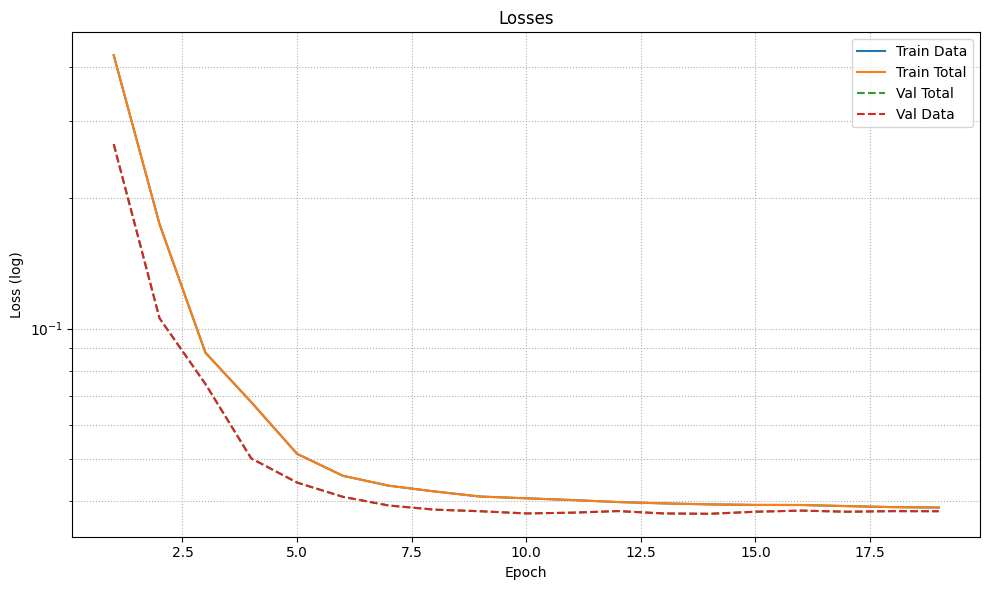

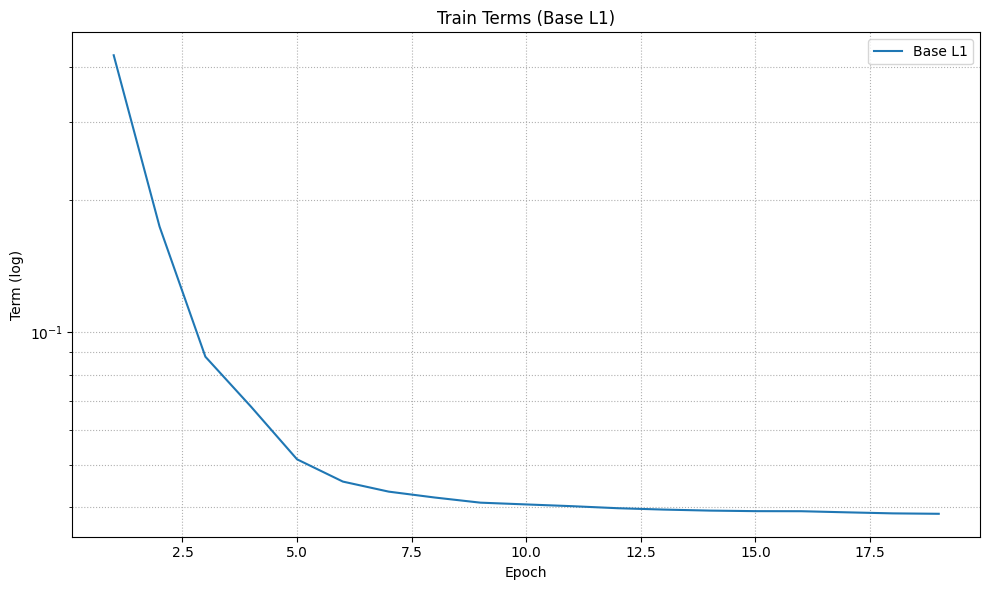

Visualizing sample index 860


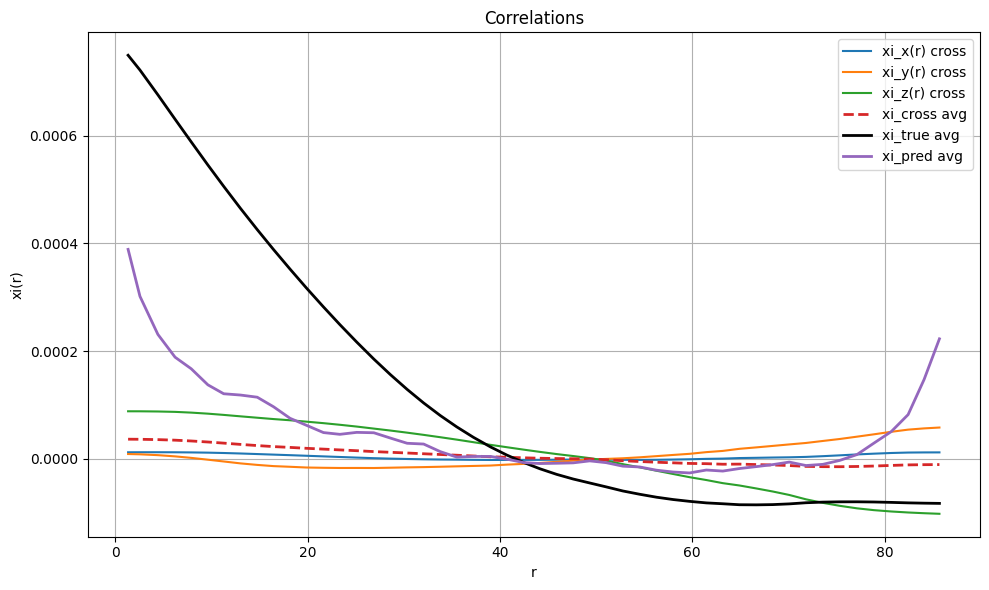

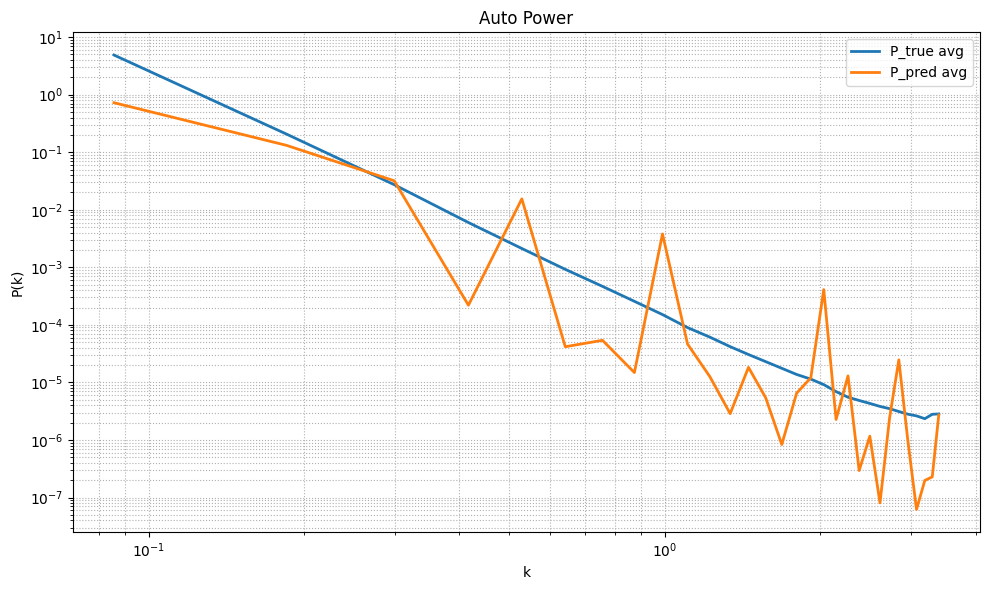

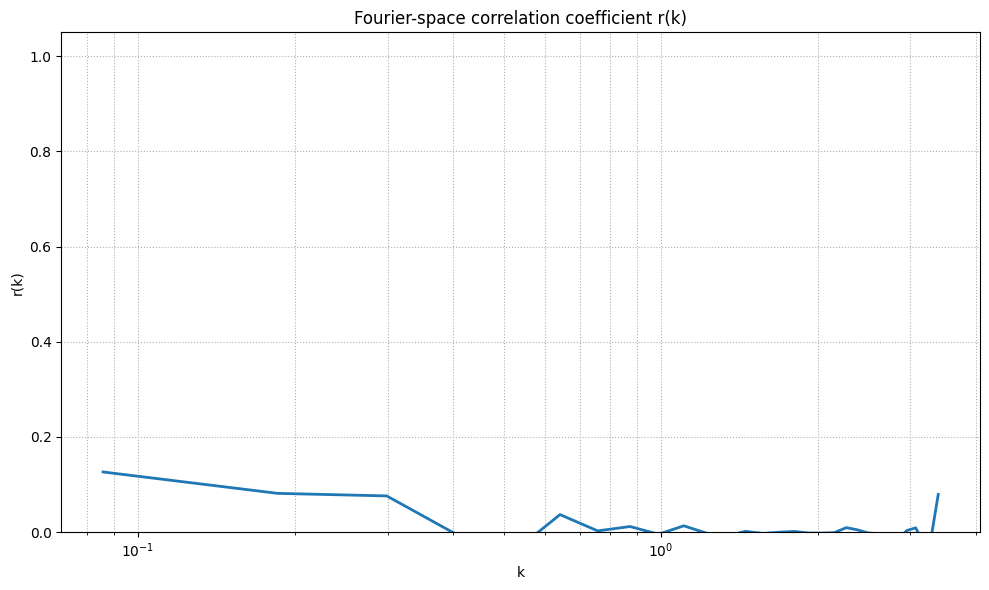

[slice] comp=0 z=32 real[min,max]=(-0.183,0.18) pred[min,max]=(-0.0633,0.121) diff[min,max]=(-0.25,0.181) scale=(-0.25,0.25)


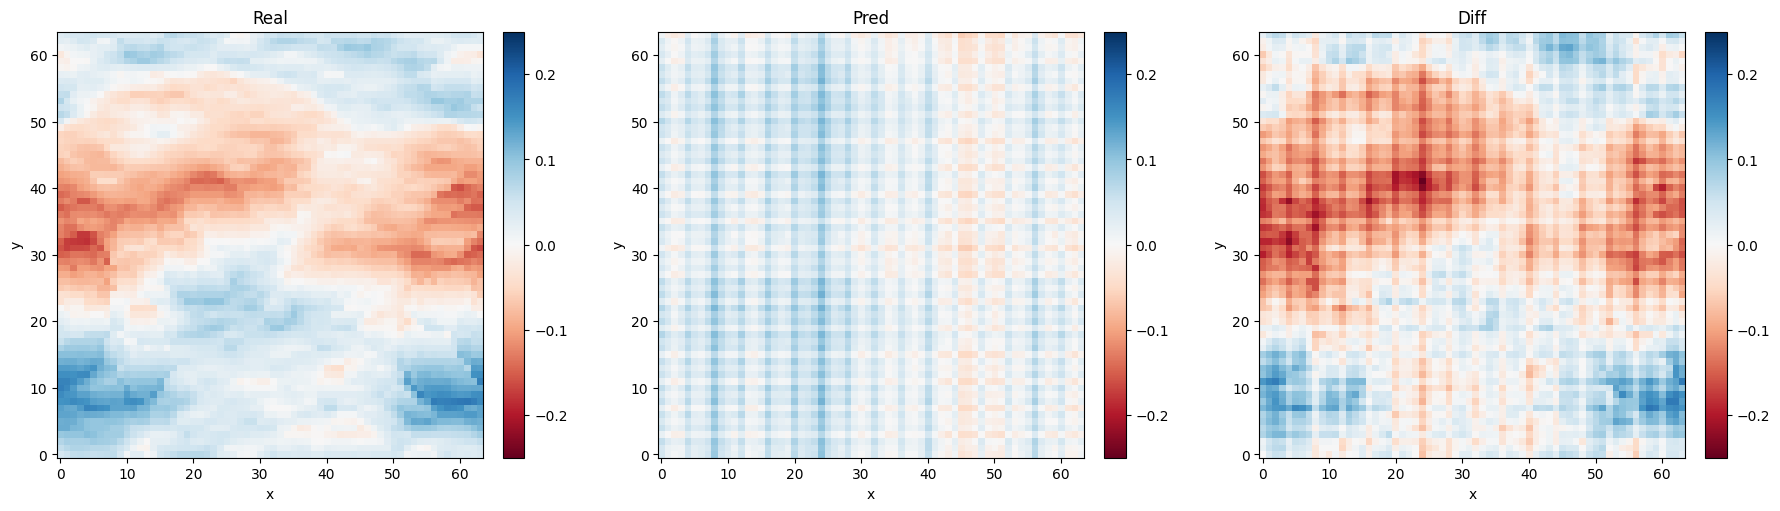

In [19]:
# Block 19: Viz (Modified for DeepONet)

# --- Helper functions (cross_correlation_function, _make_k_grid, power_spectrum_auto, power_spectrum_cross) ---
# --- remain the same. ---
def _sobel_kernels_3d(dtype, device):
    s = torch.tensor([1.0, 2.0, 1.0], dtype=dtype, device=device)
    d = torch.tensor([1.0, 0.0, -1.0], dtype=dtype, device=device)
    Gx = torch.einsum('z,y,x->zyx', s, s, d) / 32.0
    Gy = torch.einsum('z,y,x->zyx', s, d, s) / 32.0
    Gz = torch.einsum('z,y,x->zyx', d, s, s) / 32.0
    K = torch.stack([Gx, Gy, Gz], dim=0).unsqueeze(1)
    return K

def cross_correlation_function(field_a, field_b, boxsize=100.0, nbins=50, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = Fa * np.conj(Fb) / V
    xi = np.fft.ifftn(Pab).real
    coords = np.fft.fftfreq(N) * N
    z, y, x = np.meshgrid(coords, coords, coords, indexing="ij")
    r_grid = np.sqrt(x**2 + y**2 + z**2) * (boxsize / N)
    r_flat = r_grid.reshape(-1); xi_flat = xi.reshape(-1)
    rmax = np.max(r_flat); bins = np.linspace(0.0, rmax, nbins + 1)
    which = np.digitize(r_flat, bins) - 1; nbins_eff = len(bins) - 1
    xi_sum = np.zeros(nbins_eff, dtype=np.float64)
    r_sum  = np.zeros(nbins_eff, dtype=np.float64)
    cnt    = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(r_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            xi_sum[bi] += xi_flat[i]; r_sum[bi] += r_flat[i]; cnt[bi] += 1
    mask  = cnt > 0
    r_bin = r_sum[mask] / cnt[mask]; xi_r = xi_sum[mask] / cnt[mask]
    return r_bin, xi_r

def _make_k_grid(N, boxsize):
    kf = 2.0 * np.pi / boxsize
    freqs = np.fft.fftfreq(N) * N
    kz, ky, kx = np.meshgrid(freqs, freqs, freqs, indexing="ij")
    kx = kx * kf; ky = ky * kf; kz = kz * kf
    kk = np.sqrt(kx**2 + ky**2 + kz**2)
    return kx, ky, kz, kk

def power_spectrum_auto(field, boxsize=100.0, nbins=30, subtract_mean=True):
    N = field.shape[0]
    a = field.astype(np.float32, copy=False)
    if subtract_mean: a = a - np.mean(a, dtype=np.float64)
    Fa = np.fft.fftn(a); V = boxsize ** 3
    P = (Fa * np.conj(Fa)).real / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = P.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

def power_spectrum_cross(field_a, field_b, boxsize=100.0, nbins=30, subtract_mean=True):
    assert field_a.shape == field_b.shape
    N = field_a.shape[0]
    a = field_a.astype(np.float32, copy=False); b = field_b.astype(np.float32, copy=False)
    if subtract_mean:
        a = a - np.mean(a, dtype=np.float64); b = b - np.mean(b, dtype=np.float64)
    Fa = np.fft.fftn(a); Fb = np.fft.fftn(b); V = boxsize ** 3
    Pab = (Fa * np.conj(Fb)) / V
    _, _, _, kk = _make_k_grid(N, boxsize)
    k_flat = kk.reshape(-1); P_flat = Pab.real.reshape(-1)
    kmax = k_flat.max(); bins = np.linspace(0.0, kmax, nbins + 1)
    which = np.digitize(k_flat, bins) - 1; nbins_eff = len(bins) - 1
    P_sum = np.zeros(nbins_eff, dtype=np.float64)
    k_sum = np.zeros(nbins_eff, dtype=np.float64)
    cnt   = np.zeros(nbins_eff, dtype=np.int64)
    for i in range(k_flat.size):
        bi = which[i]
        if 0 <= bi < nbins_eff:
            P_sum[bi] += P_flat[i]; k_sum[bi] += k_flat[i]; cnt[bi] += 1
    mask = cnt > 0
    k_bin = k_sum[mask] / cnt[mask]; Pk = P_sum[mask] / cnt[mask]
    return k_bin, Pk

# --- Load loss histories (simplified) ---
if 'data_losses' not in globals() or not isinstance(data_losses, list) or len(data_losses) == 0:
    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location='cpu')
        data_losses       = ckpt.get('data_losses', [])
        phys_losses       = ckpt.get('phys_losses', [])
        total_losses      = ckpt.get('total_losses', [])
        base_disp_hist    = ckpt.get('base_disp_hist', [])
        # lap_losses_hist   = ckpt.get('lap_losses_hist', [])   # Removed
        # edge_losses_hist  = ckpt.get('edge_losses_hist', [])  # Removed
        # spec_low_hist     = ckpt.get('spec_low_hist', [])    # Removed
        # spec_high_hist    = ckpt.get('spec_high_hist', [])   # Removed
        val_data_losses   = ckpt.get('val_data_losses', [])
        val_phys_losses   = ckpt.get('val_phys_losses', [])
        val_total_losses  = ckpt.get('val_total_losses', [])
    else:
        # Initialize empty lists
        data_losses = phys_losses = total_losses = []
        base_disp_hist = []
        val_data_losses = val_phys_losses = val_total_losses = []

_EPS = 1e-12
def _safe_pos(seq):
    arr = np.array(seq, dtype=np.float64) if len(seq) else np.array([], dtype=np.float64)
    if arr.size: arr = np.maximum(arr, _EPS)
    return arr

# --- Modified Plot 1 (Total, Data, Phys) ---
epochs_list = list(range(1, len(data_losses) + 1))
plt.figure(figsize=(10, 6))
if len(data_losses): plt.semilogy(epochs_list, _safe_pos(data_losses), label='Train Data')
# if len(phys_losses): plt.semilogy(epochs_list, _safe_pos(phys_losses), label='Train Phys') # Optional, will be 0
if len(total_losses): plt.semilogy(epochs_list, _safe_pos(total_losses), label='Train Total')
if len(val_total_losses):
    ev = list(range(1, len(val_total_losses) + 1))
    plt.semilogy(ev, _safe_pos(val_total_losses), label='Val Total', linestyle='--')
if len(val_data_losses):
    evd = list(range(1, len(val_data_losses) + 1))
    plt.semilogy(evd, _safe_pos(val_data_losses), label='Val Data', linestyle='--')
# if len(val_phys_losses): # Optional, will be 0
#     evp = list(range(1, len(val_phys_losses) + 1))
#     plt.semilogy(evp, _safe_pos(val_phys_losses), label='Val Phys', linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('Loss (log)'); plt.title('Losses'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

# --- Modified Plot 2 (Simplified to just Base L1) ---
have_terms = len(base_disp_hist) > 0
if have_terms:
    plt.figure(figsize=(10, 6))
    if len(base_disp_hist):  plt.semilogy(range(1, len(base_disp_hist)+1),  _safe_pos(base_disp_hist),  label='Base L1')
    # Removed plots for lap, edge, spec_low, spec_high
    plt.xlabel('Epoch'); plt.ylabel('Term (log)'); plt.title('Train Terms (Base L1)'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

# --- Modified Inference/Visualization Section ---
if 'model' not in globals():
    try:
        # Re-define model architecture parameters from Block 14
        G = grid
        branch_input_dim = G * G * G
        trunk_input_dim = 3
        p_internal = 128 # Must match Block 14
        output_p = 3 * p_internal
        branch_layers = [branch_input_dim, 512, 512, output_p] # Must match Block 14
        trunk_ff_dim = 256 # Must match Block 14
        trunk_layers = [trunk_input_dim, trunk_ff_dim, 256, 256, output_p] # Must match Block 14
        trunk_freqs = 50 # Must match Block 14
        
        model = DeepONet(branch_layers, trunk_layers, trunk_freqs).to(device)
        
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Loaded best model: {best_model_path}")
        elif os.path.exists(checkpoint_path):
            ckpt = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(ckpt['model_state_dict'])
            print(f"Loaded model from checkpoint: {checkpoint_path}")
        else:
            print("No model weights found.")
    except Exception as e:
        print(f"[warn] Model build failed: {e}")

if 'dataset' not in globals():
    dataset = LSSDataset(precomputed_dir, num_sim, preload=False, cache_size=64, np_dtype=np.float32,
                         scale_disp=DISP_SCALE)

model.eval()
with torch.no_grad():
    try:
        # Get a random sample
        ridx = np.random.randint(0, len(dataset))
        print(f"Visualizing sample index {ridx}")
        # Get data in (u, y, s) format
        u_test, y_test, s_test_flat = dataset[ridx]
    except Exception as e:
        print(f"Failed to get sample for viz: {e}")
        # Use dummy data if loading fails
        u_test = torch.zeros(grid*grid*grid)
        y_test = torch.zeros(grid*grid*grid, 3)
        s_test_flat = torch.zeros(grid*grid*grid, 3)

    # Prepare inputs for DeepONet
    u_test = u_test.unsqueeze(0).to(device, dtype=torch.float32) # Add batch dim: (1, GGG)
    y_test = y_test.to(device, dtype=torch.float32)       # Already (GGG, 3)

    # Run model
    pred_flat = model(u_test, y_test).cpu().detach() # Output shape (GGG, 3)
    real_flat = s_test_flat.cpu().detach()           # Target shape (GGG, 3)

# Reshape flattened outputs back to grid format for P(k) and slice plots
G = grid
# Reshape to (G, G, G, 3) then permute to (3, G, G, G)
pred_np = pred_flat.numpy().reshape(G, G, G, 3).transpose(3, 0, 1, 2)
real_np = real_flat.numpy().reshape(G, G, G, 3).transpose(3, 0, 1, 2)

# --- Keep P(k) and Slice plotting logic (it should work with pred_np, real_np) ---
xi_cross_components = []; r_vals = None
for c in range(3):
# ... (rest of the block is unchanged) ...
    r, xi = cross_correlation_function(real_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_cross_components.append(xi)
    if r_vals is None: r_vals = r
xi_cross_avg = np.mean(np.stack(xi_cross_components, axis=0), axis=0)

xi_true_components = []
for c in range(3):
    _, xi_t = cross_correlation_function(real_np[c], real_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_true_components.append(xi_t)
xi_true_avg = np.mean(np.stack(xi_true_components, axis=0), axis=0)

xi_pred_components = []
for c in range(3):
    _, xi_p = cross_correlation_function(pred_np[c], pred_np[c], boxsize=BoxSize, nbins=50, subtract_mean=True)
    xi_pred_components.append(xi_p)
xi_pred_avg = np.mean(np.stack(xi_pred_components, axis=0), axis=0)

plt.figure(figsize=(10, 6))
for c, name in enumerate(['x', 'y', 'z']):
    plt.plot(r_vals, xi_cross_components[c], label=fr'xi_{name}(r) cross')
plt.plot(r_vals, xi_cross_avg, linestyle='--', linewidth=2.0, label='xi_cross avg')
plt.plot(r_vals, xi_true_avg, color='k', linewidth=2.0, label='xi_true avg')
plt.plot(r_vals, xi_pred_avg, linewidth=2.0, label='xi_pred avg')
plt.xlabel('r'); plt.ylabel('xi(r)'); plt.title('Correlations'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

NBINS_K = 30
Pk_true_components = []; Pk_pred_components = []; Pk_cross_components = []; k_vals = None
for c in range(3):
    k_t, Pt = power_spectrum_auto(real_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_p, Pp = power_spectrum_auto(pred_np[c],  boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    k_c, Pc = power_spectrum_cross(real_np[c], pred_np[c], boxsize=BoxSize, nbins=NBINS_K, subtract_mean=True)
    Pk_true_components.append(Pt); Pk_pred_components.append(Pp); Pk_cross_components.append(Pc)
    if k_vals is None: k_vals = k_t
Pk_true_avg  = np.mean(np.stack(Pk_true_components, axis=0), axis=0)
Pk_pred_avg  = np.mean(np.stack(Pk_pred_components, axis=0), axis=0)
Pk_cross_avg = np.mean(np.stack(Pk_cross_components, axis=0), axis=0)
eps = 1e-20
rk = Pk_cross_avg / np.sqrt((Pk_true_avg + eps) * (Pk_pred_avg + eps))

plt.figure(figsize=(10, 6))
plt.loglog(k_vals, Pk_true_avg, label='P_true avg', linewidth=2.0)
plt.loglog(k_vals, Pk_pred_avg, label='P_pred avg', linewidth=2.0)
plt.xlabel('k'); plt.ylabel('P(k)'); plt.title('Auto Power'); plt.legend(); plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(k_vals, rk, linewidth=2.0)
plt.ylim(0.0, 1.05)
plt.xlabel('k'); plt.ylabel('r(k)'); plt.title('Fourier-space correlation coefficient r(k)')
plt.grid(True, which='both', ls=':'); plt.tight_layout(); plt.show()

component = 0
slice_idx = grid // 2
real_slice = real_np[component, :, :, slice_idx]
pred_slice = pred_np[component, :, :, slice_idx]
diff_slice = real_slice - pred_slice
v = float(np.max(np.abs([real_slice, pred_slice, diff_slice]))); v = max(v, 1e-6)
vmin, vmax = -v, v
fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
im1 = axs[0].imshow(real_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[0].set_title('Real'); plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
im2 = axs[1].imshow(pred_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[1].set_title('Pred'); plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
im3 = axs[2].imshow(diff_slice, cmap='RdBu', origin='lower', vmin=vmin, vmax=vmax); axs[2].set_title('Diff'); plt.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
for ax in axs:
    ax.set_xlabel('x'); ax.set_ylabel('y')
print(f"[slice] comp={component} z={slice_idx} real[min,max]=({real_slice.min():.3g},{real_slice.max():.3g}) "
      f"pred[min,max]=({pred_slice.min():.3g},{pred_slice.max():.3g}) "
      f"diff[min,max]=({diff_slice.min():.3g},{diff_slice.max():.3g}) "
      f"scale=({vmin:.3g},{vmax:.3g})")
plt.show()